In [55]:
# Image Processing
import numpy as np

from PIL import Image
import cv2 as cv
import math

# Visualization
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

# Torch
import torch
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Etc
from tqdm import tqdm
import warnings
import os

In [8]:
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [20]:
os.environ['TORCH_HOME'] = '/scratch/cm6627/.torch_home'

In [9]:
### Format Data
inference_transform = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
my_inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])


### Import Data
data_root = '/scratch/cm6627/imagenet'

# Actual dataset with TorchTensors
dataset = datasets.ImageFolder(root=f"{data_root}/val", transform=my_inference_transforms)

# Copy of dataset for visualization
dataset_visualization = datasets.ImageFolder(root=f"{data_root}/val", transform=v2.CenterCrop(224))

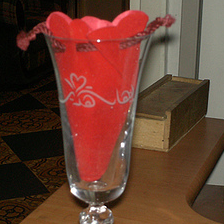

In [18]:
pic_id = 28621

dataset_visualization[pic_id][0]

# Model

In [21]:
model = torchvision.models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /scratch/cm6627/.torch_home/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 244MB/s]


In [29]:
def sin_distortion(x_length: int,
                   y_length: int,
                   A_nm: np.array) -> np.array:
  """
  Sin distortion for `cv2.remap` function.

  Args:
  - x_length (int): Length of x-axis of image.
  - y_length (int): Length of y-axis of image.
  - A_nm (np.array): Square matrix of coefficents. Sets size of cut off

  Returns:
  (np.array): Size `x_length` * `y_length`.
  """
  if A_nm.shape[0] != A_nm.shape[1]:
    raise ValueError('A_nm must be square matrix.')

  # Create Coordinates
  x = np.arange(x_length)
  y = np.arange(y_length)
  X, Y = np.meshgrid(x, y)

  # Create Diffeo
  x_pert = np.linspace(0,1, x_length)
  y_pert = np.linspace(0,1, y_length)

  n = np.arange(1,A_nm.shape[0] + 1)
  x_basis = np.sin(np.pi * np.outer(n, x_pert))
  y_basis = np.sin(np.pi * np.transpose(np.outer(n, y_pert)))

  perturbation =  y_basis @ A_nm @ x_basis

  x_map = X + perturbation
  y_map = Y + perturbation

  return np.array(x_map), np.array(y_map)

def apply_transformation(image_tensor,
                         A_nm: np.array,
                         interpolation_type =cv.INTER_LINEAR):
  """
  Wrapper of `sin_distort`. Gets torch.tensor and
  returns the distorted torch.tensor according to $A_nm$.

  Args:
    image_tensor (torch.tensor): Inputted image.
    A_nm (np.array): Characterizes diffeo according to `sin_distort`
    interpolation_type (cv.):

  Returns
    image_tensor_deformed (torch.tensor): Diffeo applied to `image_tensor`.
  """
  # Convert to numpy array
  image_numpy = image_tensor.cpu().detach().numpy()

  # Create deformation map
  x_length, y_length = tuple(image_tensor.shape[1:3])
  x_map, y_map = sin_distortion(x_length, y_length, A_nm)

  # Apply Deformation per channel
  deformed_per_channel = [cv.remap(channel, x_map, y_map, interpolation_type) for channel in image_numpy]
  image_numpy_deformed = np.stack(deformed_per_channel, axis=0)

  # Convert back to tensor
  image_tensor_deformed = torch.from_numpy(image_numpy_deformed)

  return image_tensor_deformed

In [56]:
from torch import nn

class BiasOnly_gridInv(nn.Module):
    def __init__(self, grid):
        super(BiasOnly_gridInv, self).__init__()
        self.grid = grid
        self.bias = nn.Parameter(torch.zeros_like(grid))
    def forward(self):
        return self.grid + self.bias
    
def find_inv_grid(flow_grid, mode ='bilinear', learning_rate = 0.001, epochs = 10000, early_stopping = True):
  x_length, y_length, _ = flow_grid.squeeze().shape
  x = torch.linspace(-1, 1, steps = x_length)
  y = torch.linspace(-1, 1, steps = y_length)
  X, Y = torch.meshgrid(x, y, indexing='ij')
  reference = torch.stack((X, Y, X * Y, torch.cos(2*math.pi*X) * torch.cos(2*math.pi*Y)), dim=0).unsqueeze(0)
    
  find_inv_model = BiasOnly_gridInv(torch.stack((Y, X), dim=-1).unsqueeze(0))
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(find_inv_model.parameters(), lr = learning_rate)

  num_epochs = epochs
  loss_hist = []
  min_loss = 1e30
  early_stopping_count = 0
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = find_inv_model()
    #distort = torch.nn.functional.grid_sample(reference, flow_grid, mode = mode)
    inv_distort = torch.nn.functional.grid_sample(reference, output, mode = mode)
    #restored_left  = torch.nn.functional.grid_sample(distort, output, mode = mode)
    restored_right = torch.nn.functional.grid_sample(inv_distort, flow_grid, mode = mode)
    #left_loss = loss_fn(reference, restored_left)
    right_loss = loss_fn(reference, restored_right)
    loss = right_loss #+ left_loss #+ (torch.exp(torch.abs(left_loss-right_loss)**2) - 1)
    #loss =  left_loss + right_loss
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 500 == 0:
          loss_hist.append(loss.item())
          if loss_hist[-1]/min_loss >= 0.95: early_stopping_count += 1
          if loss_hist[-1] < min_loss: min_loss = loss_hist[-1]
    if early_stopping and early_stopping_count >=5: break

  with torch.no_grad():
    flow_grid_inverse_neural = find_inv_model().detach().clone()

  return flow_grid_inverse_neural, loss_hist

## Example

In [147]:
Amn = np.array([[0.01, 0.02],[0.01,0.03]])

xmap, ymap = np.float32(sin_distortion(224,224, Amn))
xmap = torch.tensor(xmap).unsqueeze(2)
ymap = torch.tensor(ymap).unsqueeze(2)

forward_maps = torch.cat((xmap,ymap), dim = 2).unsqueeze(0)

In [ ]:
inverse_maps, _ = find_inv_grid(torch.cat((xmap,ymap), dim = 2).unsqueeze(0))

In [ ]:
pic_tensor = dataset[pic_id][0]

In [ ]:
pic_tensor_smushed = torch.nn.functional.grid_sample(pic_tensor.unsqueeze(0), forward_maps)

In [ ]:
undistorted_image = torch.nn.functional.grid_sample(pic_tensor_smushed, inverse_maps, mode = 'bilinear')

undistorted_image

In [ ]:
pic_tensor - undistorted_image[0]

In [ ]:
a = v2.ToPILImage()
a(undistorted_image[0])

In [ ]:
a(pic_tensor)

In [ ]:
a(pic_tensor_smushed[0])